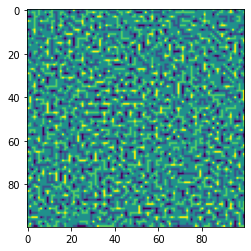

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# there is a supposedly faster perlin noise at https://pvigier.github.io/2018/06/13/perlin-noise-numpy.html

# perlin noise code from https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy
def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)
    return lerp(x1,x2,v)

def layered_perlin(x, y, seed=0, n_layers=4, persistence=0.6, lacunarity=2.2, scale=10):
    result = 0
    amplitude = 1
    frequency = 1
    
    # loop through layers
    for n in range(n_layers):
        
        # different layers have different scales
        sample_x = x / (scale / frequency)
        sample_y = y / (scale / frequency)
        
        # sample the perlin noise and add it to result
        perlinValue = perlin(sample_x, sample_y, seed + n)
        result += perlinValue * amplitude # increase result each time
        
        amplitude *= persistence # decreases each layer as persistance below 1
        frequency *= lacunarity # increases each layer
    return result

lin = np.linspace(0,50,100,endpoint=False)
x,y = np.meshgrid(lin,lin)

plt.imshow(perlin(x,y,seed=2),origin='upper')


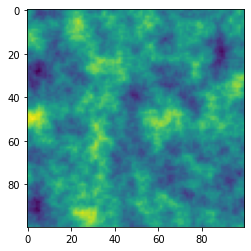

In [104]:
plt.imshow(layered_perlin(x,y,seed=2),origin='upper')

In [105]:
import random

class Star:
    CHAR = ' * '
    def __init__(self, x, y):
        self.x = x
        self.y = y   

class Chunk:
    CHUNK_SIZE = 16
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.generate_chunk(x, y)
        
    def generate_chunk(self, x, y):
        size = Chunk.CHUNK_SIZE
        self.matter = {}
        
        # generate noise for this chunk
        lin_x = np.linspace(x, x + size, size, endpoint=False)
        lin_y = np.linspace(y, y + size, size, endpoint=False)
        x,y = np.meshgrid(lin_x,lin_y)
        noise = layered_perlin(x, y)
        
        # loop through tiles to generate stars
        for row in range(size):
            for col in range(size):
                if noise[row, col] > 0.2: # noise is in range -1 to 1
                    if (random.random() < 0.2):
                        self.matter[(row, col)] = Star(row, col)
    
    def world_to_chunk_pos(x, y):
        return x % CHUNK_SIZE, y % CHUNK_SIZE
    
        
class Canvas:
    def __init__(self, size):
        self.size = size
        self.curr_x = 0
        self.curr_y = 0
        self.refresh_visible_chunk_coords()
        
    # list of chunk coords as tuples
    def refresh_visible_chunk_coords(self):
        curr_x = self.curr_x
        curr_y = self.curr_y
        self.visible_chunk_coords = []
        
        temp_x = curr_x - curr_x % Chunk.CHUNK_SIZE
        temp_y = curr_y - curr_y % Chunk.CHUNK_SIZE
        
        while temp_x < curr_x + self.size:
            while temp_y < curr_y + self.size:
                self.visible_chunk_coords.append((temp_x, temp_y))
                temp_y += Chunk.CHUNK_SIZE
            temp_x += Chunk.CHUNK_SIZE
            temp_y = curr_y - curr_y % Chunk.CHUNK_SIZE
            
    def draw_chunk_on_canvas(self, canvas, chunk):
        # loop over every tile in chunk
        for row in range(Chunk.CHUNK_SIZE):
            for col in range(Chunk.CHUNK_SIZE):
                worldx = chunk.x + row
                worldy = chunk.y + col
                canvasx, canvasy = self.world_to_canvas_pos(worldx, worldy)
                
                # if within bounds, add to canvas array
                if self.is_within_bounds(worldx, worldy):
                    if (row, col) in chunk.matter:
                        canvas[canvasx, canvasy] = chunk.matter[(row, col)].CHAR
                    else:
                        canvas[canvasx, canvasy] = '   '
                        
    def world_to_canvas_pos(self, x, y):
        return x % self.size, y % self.size
                    
    def is_within_bounds(self, x, y): # starts from top left?
        left_bound = self.curr_x
        right_bound = self.curr_x + self.size
        top_bound = self.curr_y
        low_bound = self.curr_y + self.size
        
        if x < left_bound or x >= right_bound:
            return False
        if y < top_bound or y >= low_bound:
            return False
        return True
        
        
    def render(self, universe):
        size = self.size
        self.refresh_visible_chunk_coords()
        canvas = np.full((self.size, self.size), None)
        
        # print top border
        print("/" + ("---" * size) + "\\")
        
        # put all the tiles in the chunks into one collective 2D array
        for (chunkx, chunky) in self.visible_chunk_coords:
            if (chunkx, chunky) not in universe.chunks:
                universe.chunks[(chunkx, chunky)] = Chunk(chunkx, chunky)
            self.draw_chunk_on_canvas(canvas, universe.chunks[(chunkx, chunky)])
        
        # print out the 2D array
        for row in canvas:
            print('|' + ''.join(row) + '|')
        
        # print bottom border
        print("\\" + ("---" * size) + "/")
        
class Universe:
    def __init__(self, seed):
        self.seed = seed
        self.chunks = {} # dict of chunks
        self.canvas = Canvas(40)
        
    def render(self):
        self.canvas.render(self)
        
my_universe = Universe(0)
my_universe.render()

/------------------------------------------------------------------------------------------------------------------------\
|                                              *  *                                                                      |
|                                           *                                                                            |
|                                              *                                                                         |
|                                              *                                         *                               |
|                                     *                                                                                  |
|                                                                                                                *  *    |
|                                                                                              *                       * |
|               